In [40]:
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import os
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms

In [41]:
# GLOBAL VARS
preprocess = False
# Put on False for full training set
training_size = 5000
epochs = 12
learning_rate = 3e-3

In [42]:
script_dir = os.getcwd()
emotion_processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
multi_face_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

scene_weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
scene_checkpoint = torch.hub.load_state_dict_from_url(scene_weights_url, map_location="cpu")

original_scene_model = models.resnet18(num_classes=365)
original_scene_model.fc = nn.Linear(original_scene_model.fc.in_features, 365)
scene_state_dict = {k.replace("module.", ""): v for k, v in scene_checkpoint["state_dict"].items()}
original_scene_model.load_state_dict(scene_state_dict)
original_scene_model.eval()

# Preprocessing, the standard torchvision normalization for ResNet, VGG, DenseNet...
scene_tf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [43]:
from deepproblog.network import Network 
import torch.nn.functional as F

original_hf_emotion_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

class MultiFaceWrapperFlat(nn.Module):
    def __init__(self, hf_model, max_faces=3):
        super().__init__()
        self.hf_model = hf_model
        self.max_faces = max_faces

    def forward(self, x):
        if isinstance(x, list) and len(x) == 1 and isinstance(x[0], list):
            face_tensors = x[0]
        elif isinstance(x, list):
            face_tensors = x
        else:
            face_tensors = [x]

        valid = []
        for t in face_tensors[:self.max_faces]:
            if torch.is_tensor(t):
                valid.append(t)

        # If none, create one dummy face so the shape stays consistent
        if len(valid) == 0:
            dummy = torch.zeros(3, 224, 224, device=next(self.hf_model.parameters()).device)
            valid = [dummy]

        face_batch = torch.stack(valid, dim=0)

        with torch.no_grad():
            out = self.hf_model(face_batch)
            # logits per face: [n_faces, 7]
            face_logits = out.logits

        # pad to max_faces with very negative logits (masking)
        if face_logits.size(0) < self.max_faces:
            pad = torch.full(
                (self.max_faces - face_logits.size(0), face_logits.size(1)),
                -1e9, device=face_logits.device
            )
            face_logits = torch.cat([face_logits, pad], dim=0)

        # flatten to [21] as one categorical
        flat_logits = face_logits.reshape(-1)  # [max_faces*7]
        probs = F.softmax(flat_logits, dim=-1)
        return probs


original_hf_emotion_model.eval()
for p in original_hf_emotion_model.parameters():
    p.requires_grad = False

max_faces = 3
multi_face_model = MultiFaceWrapperFlat(original_hf_emotion_model, max_faces=max_faces)

multi_face_model.eval()
for p in multi_face_model.parameters():
    p.requires_grad = False
multi_face_network = Network(multi_face_model, "multi_face_net", batching=False)
multi_face_network.optimizer = None

class Scene2EmotionNet(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=64, output_dim=7, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

        # Use Kaiming initialization for ReLU
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.fc2(x)

        probs = F.softmax(logits, dim=-1)
        return probs
    
scene2emo_model = Scene2EmotionNet()
# Trainable adapter
scene2emo_model.train()

class ScenePipeline(nn.Module):
    def __init__(self, resnet18_backbone, mlp_scene2emo):
        super().__init__()
        # frozen backbone
        self.backbone = nn.Sequential(*list(resnet18_backbone.children())[:-1])  # 512-d
        for p in self.backbone.parameters():
            p.requires_grad = False
        self.mlp = mlp_scene2emo 

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x, dim=0)
        elif x.dim() == 3:
            x = x.unsqueeze(0)
        feats = self.backbone(x)
        feats = feats.view(feats.size(0), -1)
        probs = self.mlp(feats)           # returns softmax over 7
        return probs

scene_pipeline = ScenePipeline(original_scene_model, scene2emo_model)
scene_pipeline.train()                    # only MLP is trainable
scene2emo_network = Network(scene_pipeline, "scene2emo_net", batching=True)
scene2emo_network.optimizer = torch.optim.Adam(scene2emo_network.parameters(), lr=learning_rate, weight_decay=1e-5)

In [44]:
import os
import pandas as pd
import random
from io import StringIO
import matplotlib.pyplot as plt
from IPython.display import display
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image

script_dir = os.getcwd()
labels_dir = os.path.join(script_dir, "../data/findingemo/labels")
base_findingemo_dir = os.path.join(script_dir, "../data/findingemo")
csv_path = os.path.join(labels_dir, "annotations_cleaned.csv")
df_findingEmo = pd.read_csv(csv_path)

# Get the different emotions from FindingEmo
emotion_labels_findingemo = df_findingEmo['emotion'].unique().tolist()
print(emotion_labels_findingemo)

emotion_categories = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

FindingEmo_to_basic = {
    "Anger": 0,
    "Rage": 0,
    "Annoyance": 0,
    "Loathing": 1,
    "Disgust": 1,
    "Apprehension": 2,
    "Fear": 2,
    "Terror": 2,
    "Joy": 3,
    "Serenity": 3,
    "Ecstasy": 3,
    "Admiration": 3,
    "Grief": 4,
    "Sadness": 4,
    "Pensiveness": 4,
    "Amazement": 5,
    "Surprise": 5,
    "Trust": 6,
    "Interest": 6,
    "Boredom": 6,
    "Acceptance": 6,
    "Distraction": 6
}

# Apply the mapping to create a new column with basic emotions
df_findingEmo['idx_emotion'] = df_findingEmo['emotion'].map(FindingEmo_to_basic)

# Now delete all the basic emotions that are NaN (i.e. not mapped)
df_findingEmo = df_findingEmo.dropna(subset=['idx_emotion'])
df_findingEmo['idx_emotion'] = df_findingEmo['idx_emotion'].astype(int)
df_findingEmo.tail()

['Trust', 'Interest', 'Apprehension', 'Anticipation', 'Anger', 'Joy', 'Grief', 'Serenity', 'Boredom', 'Ecstasy', 'Fear', 'Vigilance', 'Sadness', 'Rage', 'Annoyance', 'Acceptance', 'Terror', 'Amazement', 'Surprise', 'Pensiveness', 'Admiration', 'Loathing', 'Distraction', 'Disgust']


,image_path,valence,arousal,emotion,idx_emotion
21366,Run_2/Comforting soldiers conference/article-2...,-1,4,Ecstasy,3
21368,Run_2/Compassionate seniors school/Leader-1-19...,0,4,Interest,6
21369,Run_2/Satisfied students desert/justin-w-01.jpg,0,2,Admiration,3
21370,Run_2/Disgusted forty-something funeral/126268...,0,3,Acceptance,6
21371,Run_2/Irritated soldiers army/kscn0008.jpg,1,4,Pensiveness,4


In [45]:
# train_test split
from sklearn.model_selection import train_test_split
# Shuffle the dataset
df_findingEmo = df_findingEmo.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, test_df = train_test_split(df_findingEmo, test_size=0.2, random_state=42)

# reset indexes
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

if training_size != None:
    train_df = train_df.iloc[:training_size]

In [46]:
import os
import torch
import cv2
from tqdm import tqdm
from PIL import Image
from mtcnn import MTCNN

def preprocess_and_cache_faces(df, subset_name, save_dir, emotion_processor, base_dir, max_faces=3):
    os.makedirs(save_dir, exist_ok=True)
    detector = MTCNN()

    for i, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {subset_name} faces"):
        img_path = os.path.join(base_dir, row["image_path"].lstrip("/"))
        if not os.path.exists(img_path):
            print(f"Missing: {img_path}")
            continue

        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        faces = detector.detect_faces(img)

        face_tensors = []

        if len(faces) > 0:
            # Sort faces by size (descending)
            faces = sorted(faces, key=lambda f: f["box"][2] * f["box"][3], reverse=True)
            faces = faces[:max_faces]

            for face in faces:
                x, y, w, h = face["box"]
                # Ensure valid coordinates
                x, y = max(0, x), max(0, y)
                x2 = min(img.shape[1], x + w)
                y2 = min(img.shape[0], y + h)

                face_crop = img[y:y2, x:x2]
                if face_crop.shape[0] < 10 or face_crop.shape[1] < 10:
                    continue  # skip tiny detections

                face_pil = Image.fromarray(face_crop)
                face_input = emotion_processor(images=face_pil, return_tensors="pt")
                tensor = face_input["pixel_values"].squeeze(0)
                face_tensors.append(tensor)

        # Fallback if no faces detected
        if len(face_tensors) == 0:
            dummy = Image.new("RGB", (224, 224), color="gray")
            face_input = emotion_processor(images=dummy, return_tensors="pt")
            face_tensors = [face_input["pixel_values"].squeeze(0)]

        # Pad with dummy faces if < max_faces
        while len(face_tensors) < max_faces:
            dummy = Image.new("RGB", (224, 224), color="gray")
            face_input = emotion_processor(images=dummy, return_tensors="pt")
            face_tensors.append(face_input["pixel_values"].squeeze(0))

        # Stack into one tensor of shape [max_faces, 3, 224, 224] = [3 faces, 3 color channels, height, width]
        stacked = torch.stack(face_tensors[:max_faces])
        torch.save(stacked, os.path.join(save_dir, f"{i}.pt"))

save_dir_train = '../data/findingemo/precomputed/train'
save_dir_test = '../data/findingemo/precomputed/test'

if preprocess:
    preprocess_and_cache_faces(train_df, "train", save_dir_train, emotion_processor, base_findingemo_dir)
    preprocess_and_cache_faces(test_df, "test", save_dir_test, emotion_processor, base_findingemo_dir)

In [47]:
import os
import torch
import cv2
from tqdm import tqdm
from PIL import Image

def preprocess_and_cache_scenes(df, subset_name, save_dir, scene_processor, base_dir):
    os.makedirs(save_dir, exist_ok=True)

    for i, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {subset_name} scenes"):
        img_path = os.path.join(base_dir, row["image_path"].lstrip("/"))
        if not os.path.exists(img_path):
            print(f"Missing: {img_path}")
            continue

        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img)
        scene_tensor = scene_processor(img_pil)
        torch.save(scene_tensor, os.path.join(save_dir, f"{i}.pt"))


save_dir_train = '../data/findingemo/precomputed/scenes/train'
save_dir_test = '../data/findingemo/precomputed/scenes/test'

if preprocess:
    preprocess_and_cache_scenes(train_df, "train", save_dir_train, scene_tf, base_findingemo_dir)
    preprocess_and_cache_scenes(test_df, "test", save_dir_test, scene_tf, base_findingemo_dir)

In [48]:
class FindingEmoFaceImages(object):
    def __init__(self, subset):
        self.subset = subset

        if self.subset == "train":
            self.dataframe = train_df.copy()
            self.cache_dir = '../data/findingemo/precomputed/faces/train'
        else:
            self.dataframe = test_df.copy()
            self.cache_dir = '../data/findingemo/precomputed/faces/test/'

    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        try:
            cache_path = os.path.join(self.cache_dir, f"{index}.pt")
            if os.path.exists(cache_path):
                face_tensors = torch.load(cache_path)
                # Convert from stacked tensor back to list format
                if isinstance(face_tensors, torch.Tensor) and len(face_tensors.shape) == 4:
                    face_tensors = [face_tensors[i] for i in range(face_tensors.shape[0])]
                elif not isinstance(face_tensors, list):
                    face_tensors = [face_tensors]
                return face_tensors
            
            else:
                print(f"Cache file not found: {cache_path}")
                # Fallback to dummy tensor
                dummy_img = Image.new('RGB', (224, 224), color='gray')
                face_input = emotion_processor(images=dummy_img, return_tensors="pt")
                return [face_input['pixel_values'].squeeze(0)]
    
        except Exception as e:
            print(f"Error processing sample {index}: {e}")
            # Return a dummy tensor to avoid crashing
            dummy_img = Image.new('RGB', (224, 224), color='gray')
            face_input = emotion_processor(images=dummy_img, return_tensors="pt")
            return [face_input['pixel_values'].squeeze(0)]

class FindingEmoSceneImages(object):
    def __init__(self, subset):
        self.subset = subset
        if self.subset == "train":
            self.dataframe = train_df.copy()
            self.cache_dir = '../data/findingemo/precomputed/scenes/train'
        else:
            self.dataframe = test_df.copy()
            self.cache_dir = '../data/findingemo/precomputed/scenes/test'
            
    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        
        try:
            # Load cached scene tensor
            cache_path = os.path.join(self.cache_dir, f"{index}.pt")
            if os.path.exists(cache_path):
                scene_tensor = torch.load(cache_path)
                return scene_tensor
            else:
                print(f"Cache file not found: {cache_path}")
                # Add fallback
                dummy_img = Image.new('RGB', (224, 224), color='gray')
                return scene_tf(dummy_img)
                
        except Exception as e:
            print(f"Error loading cached scene tensor {index}: {e}")
            # Add fallback
            dummy_img = Image.new('RGB', (224, 224), color='gray')
            return scene_tf(dummy_img)

# Create separate instances
FindingEmoFace_train = FindingEmoFaceImages("train")
FindingEmoFace_test = FindingEmoFaceImages("test")
FindingEmoScene_train = FindingEmoSceneImages("train") 
FindingEmoScene_test = FindingEmoSceneImages("test")

In [49]:
from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.dataset import Dataset, DataLoader
from torch.utils.data import Dataset as TorchDataset
from problog.logic import Term, Constant, Var
from deepproblog.query import Query
from deepproblog.train import train_model

from deepproblog.engines import ApproximateEngine, ExactEngine
from deepproblog.optimizer import SGD

train_indices = list(range(len(train_df))) 
test_indices = list(range(len(test_df))) 

# Create model
model = Model(
    os.path.join(script_dir, "model.pl"),
    [multi_face_network, scene2emo_network]
)
model.set_engine(ExactEngine(model), cache=False)

model.optimizer = SGD(model, param_lr=learning_rate)
# from deepproblog.engines.prolog_engine.heuristics import PartialProbability
# model.set_engine(ApproximateEngine(model, k=1, heuristic=PartialProbability(), exploration=False))

# Register tensor sources
model.add_tensor_source("train_face", FindingEmoFace_train)
model.add_tensor_source("test_face", FindingEmoFace_test)
model.add_tensor_source("train_scene", FindingEmoScene_train)
model.add_tensor_source("test_scene", FindingEmoScene_test)

In [50]:
def print_faces_and_image(index, subset):
    if subset == "train":
        face_tensors = FindingEmoFace_train[(index,)]
        dataframe = train_df
    if subset == "test":
        face_tensors = FindingEmoFace_test[(index,)]
        dataframe = test_df

    # Define denormalization function for faces
    def denormalize_tensor(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        """Denormalize a tensor that was normalized with ImageNet stats"""
        mean = torch.tensor(mean).view(3, 1, 1)
        std = torch.tensor(std).view(3, 1, 1)
        denormalized = tensor * std + mean
        # Clamp values to [0, 1] range
        return torch.clamp(denormalized, 0, 1)

    # Display the faces in a row - smaller size
    num_faces = len(face_tensors)
    if num_faces > 0:
        fig, axes = plt.subplots(1, num_faces, figsize=(2 * num_faces, 2))
        if num_faces == 1:
            axes = [axes]  # Make it iterable for single face
        
        for i in range(num_faces):
            # Denormalize face tensor
            denorm_face = denormalize_tensor(face_tensors[i])
            face_img = denorm_face.permute(1, 2, 0).numpy()
            
            axes[i].imshow(face_img, aspect='equal')
            axes[i].axis('off')
            axes[i].set_title(f'Face {i+1}', fontsize=10)
        
        plt.tight_layout()
        plt.show()

    # Display the original scene image from file path
    try:
        image_path = dataframe.iloc[index]['image_path']
        if image_path.startswith('/'):
            image_path = image_path[1:]
        
        img_path = os.path.join(base_findingemo_dir, image_path)
        
        # Read original image
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'Original Scene - {dataframe.iloc[index]["emotion"]}', fontsize=12)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Could not load image: {img_path}")
            
    except Exception as e:
        print(f"Error loading original image: {e}")

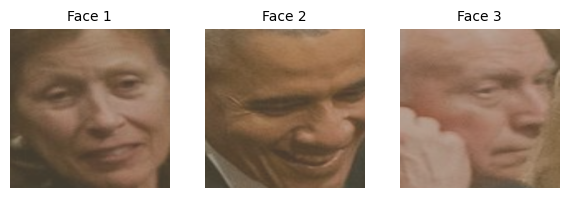

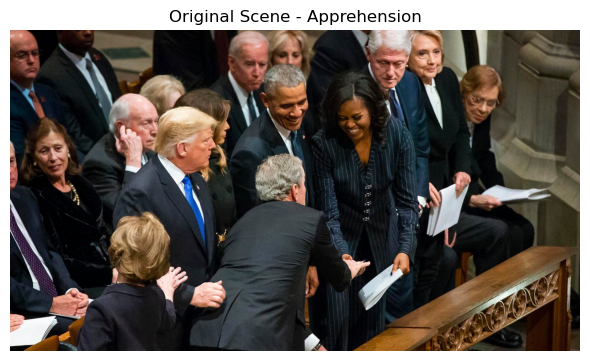

In [51]:
print_faces_and_image(7,"train")

In [52]:
import json
from typing import Tuple

# Dataset for training
class FindingEmoDataset(Dataset, TorchDataset):
    def __init__(self, dataframe, subset_name, function_name="final_findingemo"):
        super(FindingEmoDataset, self).__init__()
        self.dataframe = dataframe.reset_index(drop=True)
        self.subset_name = subset_name
        self.function_name = function_name
        self.data = list(range(len(self.dataframe)))
    
    def __getitem__(self, index: int) -> Tuple[int, str, int]:
        sample_idx = self.data[index]
        emotion_name = self.dataframe.iloc[sample_idx]['emotion']
        emotion_idx = self.dataframe.iloc[sample_idx]['idx_emotion']
        return sample_idx, emotion_name, emotion_idx
    
    def __len__(self):
        return len(self.data)
    
    def to_query(self, i: int) -> Query:
        sample_idx = self.data[i]
        emotion_idx = self.dataframe.iloc[sample_idx]['idx_emotion']
        
        query = Query(
            Term(self.function_name,
                 Term("tensor", Term(f"{self.subset_name}_face", Constant(sample_idx))),
                 Term("tensor", Term(f"{self.subset_name}_scene", Constant(sample_idx))),
                 Constant(emotion_idx)),  # Ground truth
            substitution={}
        )
        return query
    
    def get_label(self, i: int):
        sample_idx = self.data[i]
        return self.dataframe.iloc[sample_idx]['idx_emotion']
    
    def get_emotion_name(self, i: int):
        sample_idx = self.data[i]
        return self.dataframe.iloc[sample_idx]['emotion']

train_dataset = FindingEmoDataset(train_df, "train")
test_dataset = FindingEmoDataset(test_df, "test")

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Test the dataset
sample_idx, emotion_name, emotion_idx = train_dataset[0]
print(f"Sample 0: idx={sample_idx}, emotion='{emotion_name}', label={emotion_idx}")

# Test query generation
query = train_dataset.to_query(0)
print(f"Generated query: {query}")

Train dataset size: 5000
Test dataset size: 3743
Sample 0: idx=0, emotion='Acceptance', label=6
Generated query: (1.0::final_findingemo(tensor(train_face(0)),tensor(train_scene(0)),6), {})


In [53]:
# Ensure output folders exist
snapshot_dir = os.path.join(script_dir, "snapshot")
log_dir = os.path.join(script_dir, "log")
os.makedirs(snapshot_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [54]:
import torch.optim as optim
from deepproblog.train import train_model
from deepproblog.utils.stop_condition import EpochStop

loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [55]:
import gc
import torch

# Add memory cleanup before training
def cleanup_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Memory cleaned up")

cleanup_memory()

Memory cleaned up


In [56]:
res = model.solve([train_dataset.to_query(0)])
print(res[0].result)

{final_findingemo(tensor(train_face(0)),tensor(train_scene(0)),6): tensor(0.0288, grad_fn=<AddBackward0>)}


In [57]:
from deepproblog.utils.stop_condition import StopOnPlateau
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.evaluate import get_confusion_matrix

# Stop when loss stops improving
train = train_model(
    model, 
    loader, 
    EpochStop(epochs),
    loss_function_name="cross_entropy",
    log_iter=20, 
    profile=0,
    infoloss=0.2
)

Training  for 12 epoch(s)
Epoch 1
Iteration:  20 	s:33.0146 	Average Loss:  2.362027297914028
0.20556849058611695	0.13334167324828716	0.30653867272890234	0.35455116343669346
Iteration:  40 	s:35.0771 	Average Loss:  2.2010373793542386
0.21137176456370363	0.13642611365955826	0.270889290287119	0.3813128314896191
Iteration:  60 	s:34.9848 	Average Loss:  2.273567771911621
0.2105542567892768	0.14318917747571458	0.24725095730240906	0.3990056084325995
Iteration:  80 	s:35.8939 	Average Loss:  2.373385001718998
0.20773174152604507	0.1505143413405339	0.22781991423109976	0.41393400290232124
Iteration:  100 	s:35.1746 	Average Loss:  2.0906164675951002
0.1950671403519899	0.1639693779125988	0.21094476667799764	0.4300187150574137
Iteration:  120 	s:34.6532 	Average Loss:  2.2363416761159898
0.2006220303398973	0.15924115383476042	0.19648043071720603	0.4436563851081363
Iteration:  140 	s:36.6784 	Average Loss:  2.105601227283478
0.2044981049360572	0.16222334514227682	0.18494423369754096	0.4483343162